In [40]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

***Data Pre-Processing***

In [41]:
dataset = pd.read_csv("./dataset/TCS.csv")
dataset = dataset.drop(columns=['Symbol','Series','Prev Close','Last','VWAP','Turnover','Trades','Deliverable Volume','%Deliverble'])
dataset['Date'] = pd.to_datetime(dataset.Date)
dataset.head(10)

,Date,Open,High,Low,Close,Volume
0,2004-08-25,1198.7,1198.7,979.00,987.95,17116372
1,2004-08-26,992.0,997.0,975.30,979.00,5055400
2,2004-08-27,982.4,982.4,958.55,962.65,3830750
3,2004-08-30,969.9,990.0,965.00,986.75,3058151
4,2004-08-31,986.5,990.0,976.00,988.10,2649332
5,2004-09-01,990.0,995.0,983.60,987.90,2491943
6,2004-09-02,989.9,1004.6,986.00,993.65,2669544
7,2004-09-03,1006.0,1100.0,990.35,997.85,1233732
8,2004-09-06,1039.9,1039.9,992.90,994.85,1129834
9,2004-09-07,1035.0,1035.0,995.00,995.60,721529


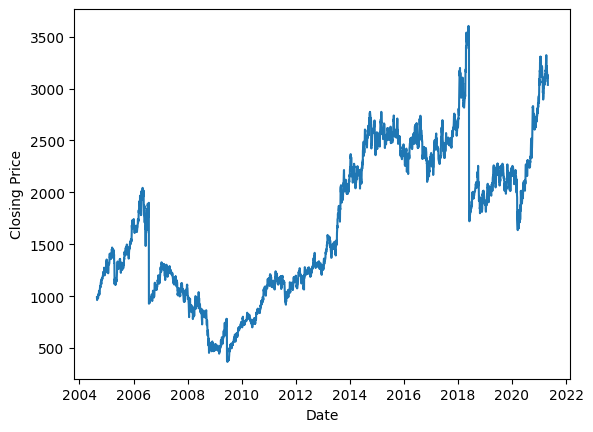

In [42]:
plt.plot(dataset['Date'],dataset['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [43]:
data = dataset.filter(['Date','Open', 'High', 'Low', 'Close'])

train_size = math.ceil(data.shape[0]*0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

In [44]:
def gen_seq(data, seq_len):
    inputs = []
    labels = []

    for i in range(seq_len, len(data)):
        inputs.append(data[i-seq_len:i, :])
        labels.append(data[i,3])
    
    return np.array(inputs), np.array(labels)

In [45]:
sc = MinMaxScaler(feature_range=(0,1))
train_data = sc.fit_transform(train.drop(columns=['Date']).values)
test_data = sc.transform(test.drop(columns=['Date']).values)

seq_len=10
x_train, y_train = gen_seq(train_data, seq_len)
x_test, y_test = gen_seq(test_data, seq_len)

In [46]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3302, 10, 4) (3302,)
(817, 10, 4) (817,)


***Model Architecture***

In [47]:
inputs = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))

x = keras.layers.Bidirectional(keras.layers.LSTM(128, activation='relu', return_sequences=True), merge_mode="sum", backward_layer=keras.layers.LSTM(128, activation='relu', go_backwards=True, return_sequences=True))(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu', return_sequences=True), merge_mode="sum", backward_layer=keras.layers.LSTM(64, activation='relu', go_backwards=True, return_sequences=True))(inputs)

x = keras.layers.LSTM(64, return_sequences=True)(x)
x = keras.layers.LSTM(32, return_sequences=True)(x)
x = keras.layers.LSTM(16)(x)

outputs = keras.layers.Dense(1)(x)

model = keras.models.Model(inputs=inputs, outputs=outputs, name='Stock_Predictor')

model.summary()

Model: "Stock_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 10, 64)         │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,921 (327.82 KB)

 Trainable params: 83,921 (327.82 KB)

 Non-trainable params: 0 (0.00 B)

***Compiling and Training***

In [48]:
loss = 'mean_squared_error'
optimizer = keras.optimizers.AdamW()

model.compile(loss=loss,optimizer=optimizer)

In [49]:
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0573 - val_loss: 0.0063
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 8.3824e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8664e-04 - val_loss: 9.0402e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.9163e-04 - val_loss: 8.2322e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.0751e-04 - val_loss: 8.1459e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4650e-04 - val_loss: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.8050e-04 - val_loss: 8.3108e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.4031e-04 - val_loss: 7.6137e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6652e-04 - val_loss: 0.0013
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.7049e-04 - val_loss: 7.5477e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.5962e-04 - val_loss: 0.0010

In [50]:
keras.saving.save_model(model, './models/stock_prediction.keras')

***Evaluation and Testing***

In [51]:
model = keras.models.load_model('./models/stock_prediction.keras')

In [52]:
model.evaluate(x_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075


0.0047705103643238544

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


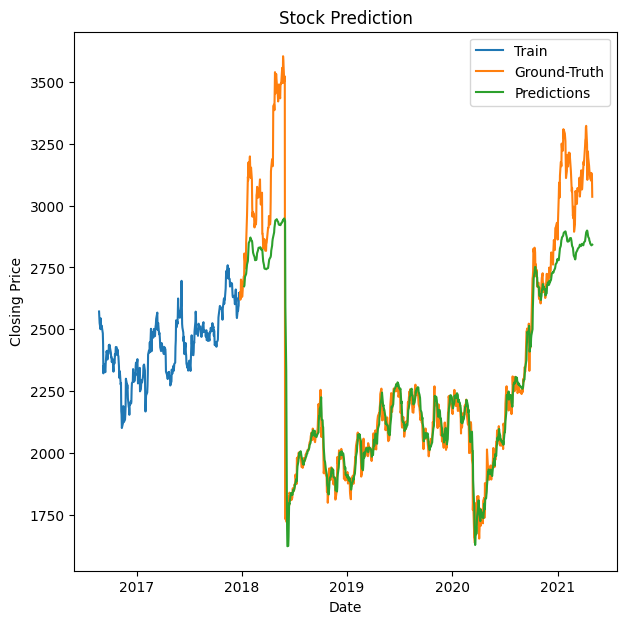

In [53]:
pred = model.predict(x_test)
pred = sc.inverse_transform(np.hstack((np.zeros((pred.shape[0],3)), pred)))[:,3].reshape(-1,1)

plt.figure(figsize=(7,7))
plt.title('Stock Prediction')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.plot(train['Date'][int(0.9*train_size):],train['Close'][int(0.9*train_size):])
plt.plot(test['Date'],test['Close'])
plt.plot(test['Date'][seq_len:], pred)
plt.legend(['Train', 'Ground-Truth', 'Predictions'])
plt.show()